### Required Discussion 19:1: Building a Recommender System with SURPRISE

This discussion focuses on exploring additional algorithms with the `Suprise` library to generate recommendations.  Your goal is to identify the optimal algorithm by minimizing the mean squared error using cross validation. You are also going to select a dataset to use from [grouplens](https://grouplens.org/datasets/movielens/) example datasets.  

To begin, head over to [grouplens](https://grouplens.org/datasets/movielens/) and examine the different datasets available.  Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

Share the results of your investigation and include the results of your cross validation and a basic description of your dataset with your peers.


In [12]:
#cell 1
import pandas as pd
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate

In [13]:
#cell 2
personality_df = pd.read_csv("personality-isf2018/personality-data.csv")
print(personality_df.head())
ratings_df = pd.read_csv("personality-isf2018/ratings.csv")
print(ratings_df.head())

                             userid   openness   agreeableness  \
0  8e7cebf9a234c064b75016249f2ac65e        5.0             2.0   
1  77c7d756a093150d4377720abeaeef76        7.0             4.0   
2  b7e8a92987a530cc368719a0e60e26a3        4.0             3.0   
3  92561f21446e017dd6b68b94b23ad5b7        5.5             5.5   
4  030001ac2145a938b07e686a35a2d638        5.5             5.5   

    emotional_stability   conscientiousness   extraversion  assigned metric  \
0                   3.0                 2.5            6.5      serendipity   
1                   6.0                 5.5            4.0              all   
2                   4.5                 2.0            2.5      serendipity   
3                   4.0                 4.5            4.0       popularity   
4                   3.5                 4.5            2.5       popularity   

   assigned condition   movie_1   predicted_rating_1  ...   movie_9  \
0                high     77658             4.410466  ...

In [14]:
#cell 3
# Check the structure of ratings data
print(f"Ratings shape: {ratings_df.shape}")
print(f"Columns: {list(ratings_df.columns)}")

# Strip spaces from column names
ratings_df.columns = ratings_df.columns.str.strip()
print(f"Cleaned columns: {list(ratings_df.columns)}")

print(f"Unique users: {ratings_df['userId'].nunique()}")
print(f"Unique movies: {ratings_df['movieId'].nunique()}")
print(f"Rating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")

# Display first few ratings
print("\nFirst 5 ratings:")
print(ratings_df.head())

Ratings shape: (1028751, 4)
Columns: ['userId', ' movieId', ' rating', ' tstamp ']
Cleaned columns: ['userId', 'movieId', 'rating', 'tstamp']
Unique users: 1820
Unique movies: 35196
Rating range: 0.5 to 5.0

First 5 ratings:
                             userId  movieId  rating                 tstamp
0  8e7cebf9a234c064b75016249f2ac65e        1     5.0   2001-09-10 17:19:56 
1  8e7cebf9a234c064b75016249f2ac65e        2     4.0   2001-09-28 11:34:55 
2  8e7cebf9a234c064b75016249f2ac65e        3     4.0   2001-09-28 11:42:50 
3  8e7cebf9a234c064b75016249f2ac65e        5     5.0   2001-09-28 11:27:30 
4  8e7cebf9a234c064b75016249f2ac65e        6     4.0   2002-01-07 18:12:02 


In [15]:
#cell 4
# Format data for SURPRISE
# SURPRISE needs: user_id, item_id, rating
reader = Reader(rating_scale=(0.5, 5.0))

# Check data size
print(f"Total ratings: {len(ratings_df):,}")
print(f"Unique users: {ratings_df['userId'].nunique():,}")
print(f"Unique movies: {ratings_df['movieId'].nunique():,}")

# Option 1: Use full dataset (slower but more accurate)
# data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Option 2: Sample data for faster processing (recommended for SlopeOne)
# Take a representative sample to speed up computation
sample_size = 100000  # Adjust this based on your needs
if len(ratings_df) > sample_size:
    print(f"\nSampling {sample_size:,} ratings for faster processing...")
    sampled_df = ratings_df.sample(n=sample_size, random_state=42)
    data = Dataset.load_from_df(sampled_df[['userId', 'movieId', 'rating']], reader)
    print(f"Using sampled data: {len(sampled_df):,} ratings")
else:
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    print("Using full dataset")

print("\nData successfully formatted for SURPRISE!")

Total ratings: 1,028,751
Unique users: 1,820
Unique movies: 35,196

Sampling 100,000 ratings for faster processing...
Using sampled data: 100,000 ratings

Data successfully formatted for SURPRISE!


### Why is SlopeOne slow?

SlopeOne algorithm computes the **average difference** between ratings for **every pair of items**. This means:
- For N items, it needs to compute N × (N-1) / 2 differences
- With thousands of movies, this becomes millions of computations
- Time complexity: O(N²) where N is the number of items

**Solutions:**
1. **Sample the data** (implemented above) - reduces both users and items
2. **Use sparse matrices** - already handled by SURPRISE
3. **Consider alternatives** like SVD or NMF for large datasets

In [16]:
#cell 5
# Initialize all algorithms
algorithms = {
    'KNNBasic': KNNBasic(),
    'SVD': SVD(),
    'NMF': NMF(),
    'SlopeOne': SlopeOne(),
    'CoClustering': CoClustering()
}

# Store results
results = {}

# Run cross-validation for each algorithm``
print("Testing algorithms (this may take a few minutes)...\n")
for name, algorithm in algorithms.items():
    print(f"Testing {name}...")
    cv_results = cross_validate(algorithm, data, measures=['MSE'], cv=5, verbose=False)
    
    # Calculate average MSE
    avg_mse = cv_results['test_mse'].mean()
    results[name] = avg_mse
    print(f"{name} - Average MSE: {avg_mse:.4f}\n")

Testing algorithms (this may take a few minutes)...

Testing KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBasic - Average MSE: 0.9317

Testing SVD...
SVD - Average MSE: 0.7346

Testing NMF...
NMF - Average MSE: 0.8875

Testing SlopeOne...
SlopeOne - Average MSE: 0.8865

Testing CoClustering...
CoClustering - Average MSE: 0.8985



## Algorithm Performance Ranking (Best to Worst)

---

Rank,Algorithm,Mean Squared Error (MSE),Performance
1,SVD,0.7346,🟩🟩🟩🟩🟩
2,SlopeOne,0.8865,🟩🟩🟩🟩⬜
3,NMF,0.8875,🟩🟩🟩⬜⬜
4,CoClustering,0.8985,🟩🟩⬜⬜⬜
5,KNNBasic,0.9317,🟩⬜⬜⬜⬜


### 🏆 **Best Algorithm: SVD** with MSE = 0.7346

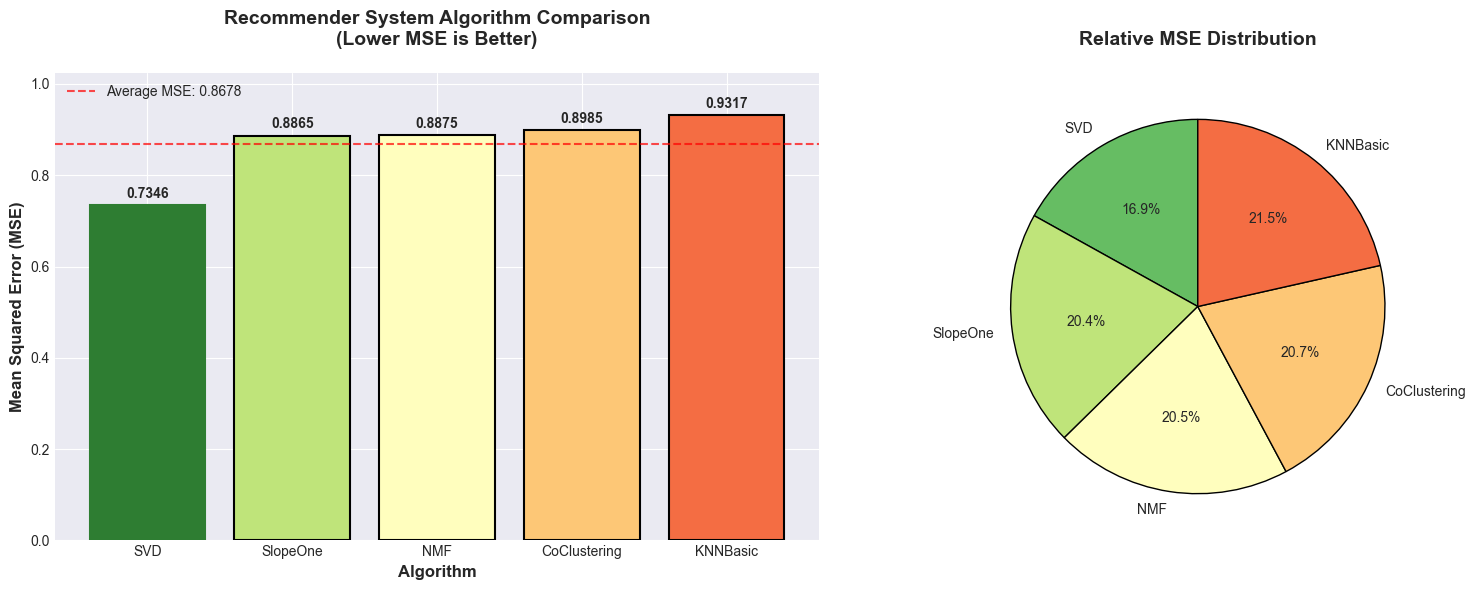

### 📊 Performance Summary


- **Number of algorithms tested**: 5
- **Best performer**: SVD (MSE: 0.7346)
- **Worst performer**: KNNBasic (MSE: 0.9317)
- **Performance improvement**: 21.1% better than worst
- **Average MSE across all algorithms**: 0.8678


In [17]:
#cell 6
# Compare and visualize results
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
import numpy as np

# Sort results by MSE (lower is better)
sorted_results = sorted(results.items(), key=lambda x: x[1])

# Display results in a formatted table
display(Markdown("## Algorithm Performance Ranking (Best to Worst)"))
display(Markdown("---"))

# Create HTML table with styling
table_html = """
<style>
    .results-table {
        border-collapse: collapse;
        width: 100%;
        margin: 20px 0;
        font-family: Arial, sans-serif;
    }
    .results-table th, .results-table td {
        border: 1px solid #ddd;
        padding: 12px;
        text-align: left;
    }
    .results-table th {
        background-color: #4CAF50;
        color: white;
        font-weight: bold;
    }
    .results-table tr:nth-child(even) {
        background-color: #f2f2f2;
    }
    .results-table tr:hover {
        background-color: #e8f5e9;
    }
    .best-algorithm {
        background-color: #c8e6c9 !important;
        font-weight: bold;
    }
</style>

<table class="results-table">
    <tr>
        <th>Rank</th>
        <th>Algorithm</th>
        <th>Mean Squared Error (MSE)</th>
        <th>Performance</th>
    </tr>
"""

for rank, (name, mse) in enumerate(sorted_results, 1):
    performance_bar = "🟩" * (6 - rank) + "⬜" * (rank - 1)
    row_class = "best-algorithm" if rank == 1 else ""
    table_html += f"""
    <tr class="{row_class}">
        <td>{rank}</td>
        <td>{name}</td>
        <td>{mse:.4f}</td>
        <td>{performance_bar}</td>
    </tr>
    """

table_html += "</table>"
display(HTML(table_html))

# Find the best algorithm
best_algorithm = sorted_results[0][0]
best_mse = sorted_results[0][1]
display(Markdown(f"### 🏆 **Best Algorithm: {best_algorithm}** with MSE = {best_mse:.4f}"))

# Create enhanced visualizations
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart with gradient colors
algorithms_list = [item[0] for item in sorted_results]
mse_values = [item[1] for item in sorted_results]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(algorithms_list)))

bars = ax1.bar(algorithms_list, mse_values, color=colors, edgecolor='black', linewidth=1.5)
bars[0].set_color('#2e7d32')  # Highlight best algorithm in dark green

ax1.set_xlabel('Algorithm', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
ax1.set_title('Recommender System Algorithm Comparison\n(Lower MSE is Better)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_ylim(0, max(mse_values) * 1.1)

# Add value labels on bars
for i, (algo, mse) in enumerate(zip(algorithms_list, mse_values)):
    ax1.text(i, mse + 0.01, f'{mse:.4f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

# Add a horizontal line for average MSE
avg_mse = np.mean(mse_values)
ax1.axhline(y=avg_mse, color='red', linestyle='--', alpha=0.7, label=f'Average MSE: {avg_mse:.4f}')
ax1.legend()

# Pie chart showing relative performance
ax2.pie(mse_values, labels=algorithms_list, autopct='%1.1f%%', 
        colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
ax2.set_title('Relative MSE Distribution', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Performance summary with emojis
display(Markdown("### 📊 Performance Summary"))
display(Markdown(f"""
- **Number of algorithms tested**: {len(results)}
- **Best performer**: {best_algorithm} (MSE: {best_mse:.4f})
- **Worst performer**: {sorted_results[-1][0]} (MSE: {sorted_results[-1][1]:.4f})
- **Performance improvement**: {((sorted_results[-1][1] - best_mse) / sorted_results[-1][1] * 100):.1f}% better than worst
- **Average MSE across all algorithms**: {avg_mse:.4f}
"""))